## 5.3.1 Gaussian distribution and Hermite Chaos

$$ f(k) = \frac{1}{\sqrt{2\pi}} e^{-\frac{k^2}{2}}$$

$$ \zeta \sim N(0,1)$$

[Wiki - Hermite Polynomial](https://en.wikipedia.org/wiki/Hermite_polynomials)

[Normal distribution in Python](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html)

[Hermite Polynomial Python](https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.polynomials.hermite_e.html)


Hermite Polynomial: (probabilists' Hermite polynomials)

$$
\begin{align*}
H_0 &= 1\\
H_1 &= x\\
H_2 &= x^2 - 1\\
H_3 &= x^3 - 3x\\
H_4 &= x^4 - 6x^2 + 3\\
&\cdots
\end{align*}
$$

Corresponding Hypergeometric orthogonal polynomial
$$ H_n(x) =(2x)^n \ _2F_0(-\frac{n}{2},-\frac{n-1}{2};;-\frac{1}{x^2})$$

In [5]:
import numpy as np
import numpy.polynomial.hermite_e as H 
from math import factorial
from scipy.stats import norm
from scipy.integrate import odeint
from matplotlib import pyplot as plt
%matplotlib notebook

`H.hermeval(x, c)`

In [2]:
def Phi(n):
    #define H_n
    coeffs = [0]*(n+1)
    coeffs[n] = 1
    return coeffs

def inner2_herm(n):       ###return the denominator when computing $k_i$
    return factorial(n)

def product3_herm(i,j,l):
    #compute \Phi_i*\Phi_j*\Phi_l
    return lambda x: H.hermeval(x, H.hermemul(H.hermemul(Phi(i),Phi(j)),Phi(l))) 

def inner3_herm(P,i,j,l):
    #compute <\Phi_i\Phi_j\Phi_l>
    
    #Set up Gauss-Hermite quadrature, weighting function is exp^{-x^2}
    m=(P+1)**2
    x, w=H.hermegauss(m)        
    inner=sum([product3_herm(i,j,l)(x[idx]) * w[idx] for idx in range(m)])         
    
    return inner/np.sqrt(2*np.pi)   #because of the weight

[Gauss Hermite Quadrature](https://en.wikipedia.org/wiki/Gauss–Hermite_quadrature)

In [3]:
def ode_system_herm(y, t, P):   
    #P indicates the highest degree
    dydt = np.zeros(P+1) 
    for l in range(len(dydt)):
        dydt[l] = -(sum(sum(inner3_herm(P,i,j,l)*ki_herm[i]*y[j] for j in range(P+1)) for i in range(P+1)))/inner2_herm(l)
    return dydt

In [4]:
P=4
ki_herm = [0,1]+[0]*(P-1)
sol_herm = odeint(ode_system_herm, [1.0]+[0.0]*P, np.linspace(0,1,101), args=(P,)) 

<IPython.core.display.Javascript object>


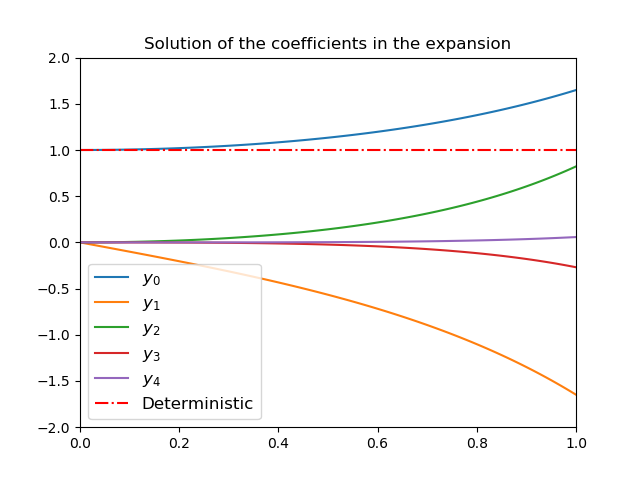

In [6]:
plt.figure()
plt.ylim([-2,2])
plt.xlim([0,1])

plt.title('Solution of the coefficients in the expansion')
for i in range(P+1):
    plt.plot(np.linspace(0,1,101),sol_herm[:,i],label='$y_'+str(i)+'$')
    
plt.axhline(y=1.0, color='r', linestyle='-.',label='Deterministic')
plt.legend(fontsize=12)#prop={'size': 8}

### Error plot
$$
\bar{y}_{exact}(t) = \hat{y_0} e^{\frac{t^2}{2}}\ \ \ \ \ \ \ \ \bar{y}(t) = y_0
$$
So 
$$
\epsilon_{mean}(t) = \left| \frac{y_0 - \hat{y_0} e^{\frac{t^2}{2}}}{\hat{y_0}e^{\frac{t^2}{2}}}\right|
$$

$$
\sigma_{exact}(t) = \hat{y_0}^2 (e^{2t^2} - e^{t^2}) \ \ \ \ \ \ \ \ \sigma(t) = y_1^2 +2y_2^2+6y_3^2+24y_4^2
$$
The coefficients in $\sigma(t)$ can be obtained by code below.

So
$$
\epsilon_{variance}(t) = \left| \frac{\sigma(t) - \sigma_{exact}(t)}{\sigma_{exact}(t)} \right|= \ldots
$$

`expect(func, args=(), loc=0, scale=1, lb=None, ub=None, conditional=False, **kwds)`

In [ ]:
np.e**2-np.e

In [7]:
def g(params):
    n = params
    return lambda u: (H.hermeval(u,Phi(n)))**2

for i in range(1,5):
    print(norm.expect(g(i), args=(), loc=0, scale=1, lb=None, ub=None, conditional=False))

1.000000000000001
2.000000000000005
6.000000000000001
24.000000000000007


Only look at when $t=1$, show the plot of relative error of mean and variance by using different orders of Hermite Chaos

In [8]:
allcoeff_531 = np.zeros((5,4))   #store ki value/ column 0 stores ki when P=1; column 1 stores ki when P=2
allcoeff_531[1,:]=np.ones(4)
y_531 = np.zeros((5,4))   #row 0 stores y0 for each P from 1-4; row 1 stores y1 for P from 1-4;...

for i in range(4):
    P=i+1
    ki_herm = allcoeff_531[:,i]
    y_mid=odeint(ode_system_herm, [1.0]+[0.0]*P, np.linspace(0,1,2), args=(P, ))[1,:]
    y_531[:,i] = y_mid.tolist()+[0]*(4-P)

In [9]:
y_531

array([[ 1.54308068,  1.63819256,  1.64796906,  1.64867952],
       [-1.17520125, -1.5805867 , -1.6423493 , -1.64828336],
       [ 0.        ,  0.63819256,  0.80057968,  0.82228702],
       [ 0.        ,  0.        , -0.22373587, -0.26894552],
       [ 0.        ,  0.        ,  0.        ,  0.05786917]])

In [10]:
error_mean_531=np.abs((y_531[0,:]-np.e**(1/2))/(np.e**(1/2)))

sigma2_531=np.zeros(4)
for i in range(4):
    sigma2_531[i]=y_531[1,i]**2+2*y_531[2,i]**2+6*y_531[3,i]**2+24*y_531[4,i]**2
    
sigma2_exact_531 = np.e**2-np.e
error_var_531=np.abs((sigma2_531-sigma2_exact_531)/sigma2_exact_531)

<IPython.core.display.Javascript object>


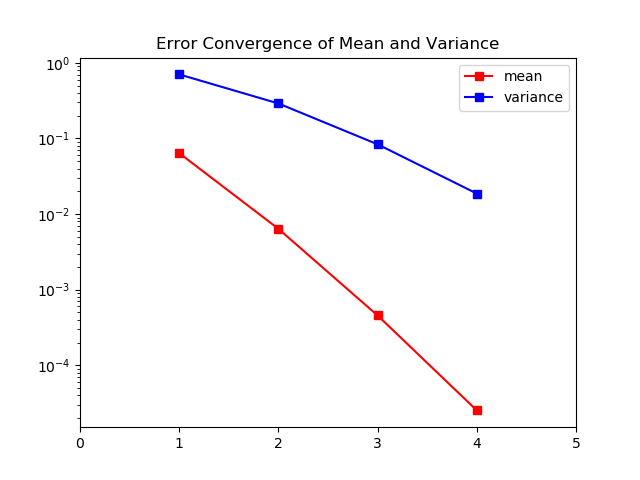

In [11]:
plt.figure()
plt.xlim([0,5])

plt.title('Error Convergence of Mean and Variance')
plt.semilogy([1,2,3,4],error_mean_531,'-rs',label='mean')
plt.semilogy([1,2,3,4],error_var_531,'-bs',label='variance')     

plt.legend()